In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [3]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('default')
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [5]:

from tensorflow import keras
import keras_tuner as kt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [6]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

In [8]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load Data
Here we will load the data from IU and CU (Piccirillo)

In [9]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')

In [10]:
# add labtype column and set it to 0 if lab is 'Dipersio' else 1
dataset['labtype'] = dataset['lab'].apply(lambda x: 0 if x == 'Dipersio' else 1)
dataset = dataset.drop(columns=['lab'])

# move labtype to the 3rd column
cols = dataset.columns.tolist()
cols.insert(2, cols.pop(cols.index('labtype')))
dataset = dataset[cols]


In [11]:
dataset.drop(columns=['Day 1 CD34 Absolute per uL'], inplace=True)

In [12]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [13]:

FEATURES    = dataset.columns.difference(['Count'])   # all but target
NUMERICS    = FEATURES.difference(['labtype']) # all numeric features

X_full      = dataset[FEATURES].copy()
y_full      = dataset['Count'].values
# X_full = X.copy()
# y_full = y.values

# perform train-test split
# 80% train, 20% test, then 80% train, 20% validation
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_full, y_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_full)

X_val, X_test, y_val, y_test   = train_test_split(
    X_tmp,  y_tmp,  test_size=0.20, random_state=RANDOM_STATE, stratify=y_tmp)

In [14]:
scaler = StandardScaler()
X_train[NUMERICS] = scaler.fit_transform(X_train[NUMERICS])
X_val[NUMERICS]   = scaler.transform(X_val[NUMERICS])
X_test[NUMERICS]  = scaler.transform(X_test[NUMERICS])

# SMOTE on *training* fold only     #
smote = SMOTE(random_state=RANDOM_STATE)
X_tr_over, y_tr_over = smote.fit_resample(X_train, y_train)
print(pd.Series(y_tr_over).value_counts())


0    739
1    739
Name: count, dtype: int64


In [15]:
X_tr_over = X_train.copy()
y_tr_over = y_train.copy()

In [16]:
from hspc.model import (
    build_attention_lab_model,
    train_attention_lab_model,
    extract_attention_weights
)


In [17]:
n_feat = len(NUMERICS)  # numeric  + age + gender   (excl. labtype)

# ── Inputs ──────────────────────────────────────────────────────────────
feat_in = layers.Input(shape=(n_feat,),   name='features')   # tensor A
lab_in  = layers.Input(shape=(1,),        name='labtype')    # tensor B

# ── Custom feature-wise attention modulated by labtype ──────────────────
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

att_layer             = FeatureAttention(n_feat)
att_out, att_weights  = att_layer([feat_in, lab_in])

# ── Down-stream classifier ──────────────────────────────────────────────
x = layers.Dense(264, activation='leaky_relu', 
                 kernel_initializer='normal',
                 kernel_regularizer = regularizers.l2(0.02)
                 )(att_out)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu', 
                 kernel_initializer='normal', 
                 kernel_regularizer=regularizers.l2(0.02)
                 )(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
logit = layers.Dense(1, activation='sigmoid')(x)

model   = models.Model(inputs=[feat_in, lab_in], outputs=logit, name='CBC_Attn_CLF')
att_extractor = models.Model(inputs=[feat_in, lab_in], outputs=att_weights)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='acc')])

model.summary()

In [18]:
# preparing numpy matric
def split_xy(frame):
    f = frame.drop(columns=['labtype']).values.astype(np.float32)
    l = frame[['labtype']].values.astype(np.float32)
    return f, l

X_tr_f, X_tr_lab = split_xy(X_tr_over)
X_v_f,  X_v_lab  = split_xy(X_val)
X_te_f, X_te_lab = split_xy(X_test)


In [19]:
# train the network
es = callbacks.EarlyStopping(monitor='val_auc', mode='max',
                             patience=10, restore_best_weights=True)

hist = model.fit([X_tr_f, X_tr_lab], y_tr_over,
                 validation_data=([X_v_f, X_v_lab], y_val),
                 epochs=250, batch_size=128,
                #  callbacks=[es],
                 verbose=2)


In [20]:
# save the model
model.save(here() / config.model_dl / 'attention_aware_DL_model_1.keras')

In [21]:
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

model = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_aware_2.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [22]:

model = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_aware_2.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [23]:
y_prob = model.predict([X_te_f, X_te_lab]).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
              precision    recall  f1-score   support

           0      0.816     0.838     0.827        37
           1      0.833     0.811     0.822        37

    accuracy                          0.824        74
   macro avg      0.825     0.824     0.824        74
weighted avg      0.825     0.824     0.824        74



In [25]:
y_prob = model.predict([X_te_f, X_te_lab]).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

           0      0.780     0.865     0.821        37
           1      0.848     0.757     0.800        37

    accuracy                          0.811        74
   macro avg      0.814     0.811     0.810        74
weighted avg      0.814     0.811     0.810        74



In [26]:
att_test = att_extractor.predict([X_te_f, X_te_lab])
att_df   = pd.DataFrame(att_test, columns=X_train.drop(columns=['labtype']).columns)
att_df['labtype'] = X_test['labtype'].values

attention_df['labtype'] = att_df['labtype'].values


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [27]:
attention_df

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,labtype
0,0.244744,0.158896,0.103815,0.060219,0.052549,0.080725,0.305613,0.071371,0.058473,0.093922,0.053494,0.054329,0.057592,0.054259,0.0
1,0.099989,0.063834,0.242606,0.056660,0.052000,0.234655,0.327688,0.087496,0.052761,0.059652,0.052593,0.060275,0.058078,0.051714,1.0
2,0.258794,0.054039,0.262050,0.055483,0.051295,0.112471,0.305467,0.077368,0.053757,0.058340,0.051236,0.054680,0.053494,0.051528,1.0
3,0.097474,0.224854,0.067451,0.059002,0.052857,0.334751,0.216313,0.079307,0.055411,0.081946,0.055253,0.060384,0.061534,0.053462,0.0
4,0.084937,0.101167,0.089716,0.063005,0.052850,0.365731,0.224349,0.083833,0.058627,0.091483,0.055070,0.063479,0.061264,0.054489,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.153034,0.269462,0.083482,0.058729,0.052498,0.110832,0.291976,0.068701,0.055888,0.086823,0.053391,0.053957,0.057738,0.053489,0.0
70,0.260326,0.066759,0.189409,0.054170,0.051342,0.092026,0.447414,0.067290,0.052963,0.059604,0.051243,0.052317,0.053605,0.051531,1.0
71,0.196379,0.175421,0.090676,0.059482,0.051967,0.151248,0.298636,0.068093,0.055777,0.086801,0.052714,0.053711,0.056098,0.052997,0.0
72,0.286029,0.106816,0.110398,0.063457,0.052404,0.127397,0.257208,0.070886,0.058548,0.096681,0.053122,0.055392,0.057370,0.054292,0.0


In [29]:
att_test = att_extractor.predict([X_te_f, X_te_lab])
att_df   = pd.DataFrame(att_test, columns=X_train.drop(columns=['labtype']).columns)
att_df['labtype'] = X_test['labtype'].values

attention_df['labtype'] = att_df['labtype'].values


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


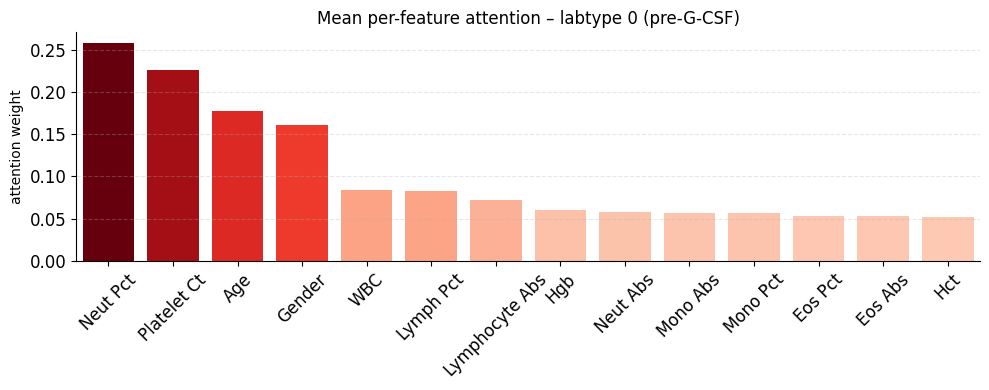

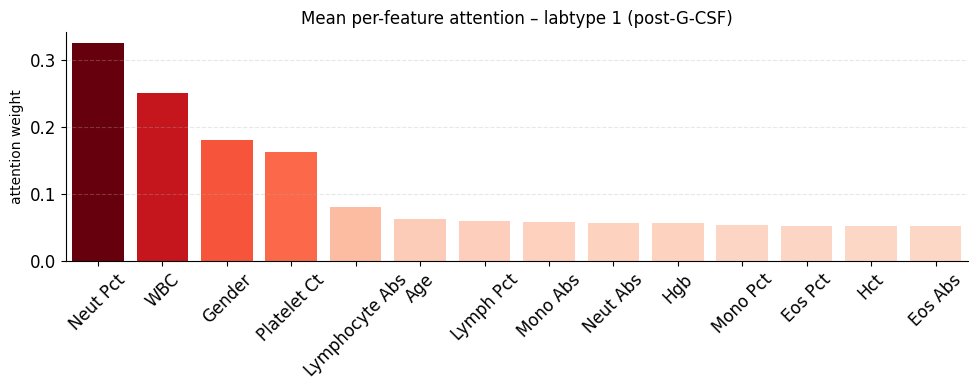

In [30]:
for lt in (0,1):
    mean_w = attention_df[attention_df.labtype==lt].drop(columns=['labtype']).mean()
    ax = plt.figure(figsize=(10,4))
    # sort the mean weights for better visualization
    mean_w = mean_w.sort_values(ascending=False)
    mean_w.plot(kind='bar')
    plt.title(f'Mean per-feature attention – labtype {lt} '
              f"({'post' if lt==1 else 'pre'}-G-CSF)")
    plt.ylabel('attention weight')
    # make the axes size thicker for better visibility
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # use gradiend color for bars
    plt.bar(mean_w.index, mean_w.values, color=plt.cm.Reds(mean_w.values / mean_w.max()))
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.png', bbox_inches='tight')
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.pdf', bbox_inches='tight')
    sns.despine()
    plt.tight_layout()
    plt.show()


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acur = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {acur:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.2f}")

Precision: 0.85
Recall: 0.76
F1 Score: 0.80
Accuracy: 0.81
AUC: 0.89
Matthews Correlation Coefficient: 0.63


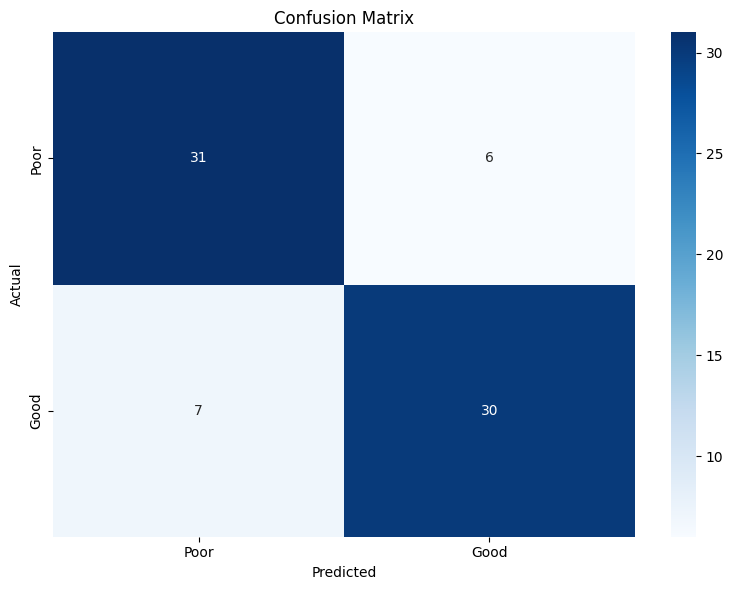

In [32]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = True, xticklabels=['Poor', 'Good'], yticklabels=['Poor', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.png', dpi = 500, bbox_inches='tight')
# plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.pdf', dpi = 300, bbox_inches='tight')
plt.tight_layout()
plt.show()

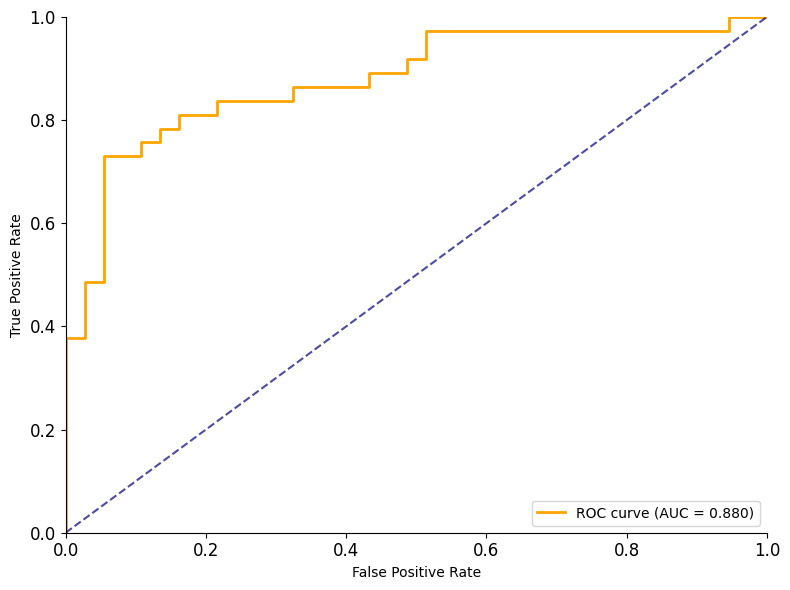

In [33]:
# plot auc curve
fpr, tpr, _ = roc_curve(y_test, y_prob)  # Use y_prob instead of y_pred
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.3f})',color = 'orange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('CBC Mobilizer Classifier – ROC Curve')
plt.legend(loc='lower right')
# plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 1)  # Ensure x-axis starts at 0
plt.ylim(0, 1)  # Ensure y-axis starts at 0
sns.despine()
plt.tight_layout()  
# plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.png', dpi = 500, bbox_inches='tight')
# plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.pdf', dpi = 300, bbox_inches='tight')
plt.show()

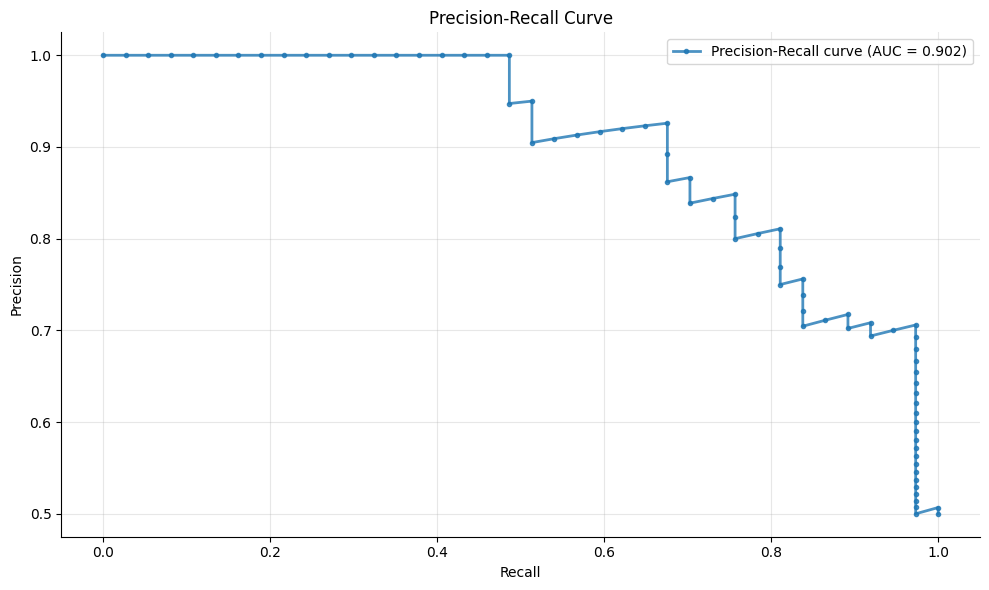

In [34]:

# plot precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
average_precision = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_score = auc(recall, precision)
plt.figure(figsize=(10, 6))
# smooth the curve by plotting points
# plt.plot(recall, precision, marker='.', label=f'Average Precision: {average_precision:.2f}')

plt.plot(recall, precision, marker = '.', label=f'Precision-Recall curve (AUC = {auc_score:0.3f})',
         linewidth=2, alpha=0.8)

# # Calculate positive class proportion for baseline
# positive_ratio = np.sum(y_test) / len(y_test)
# plt.axhline(y=positive_ratio, color='gray', linestyle='--', alpha=0.7, 
#            label=f'Random baseline ({positive_ratio:.3f})')

# plt.xlim(0, 1)  # Ensure x-axis starts at 0
# plt.ylim(0, 1)  # Ensure y-axis starts at 0
plt.legend(loc='upper right')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_precision_recall_curve.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_precision_recall_curve.pdf',dpi = 300, bbox_inches='tight')
plt.show()

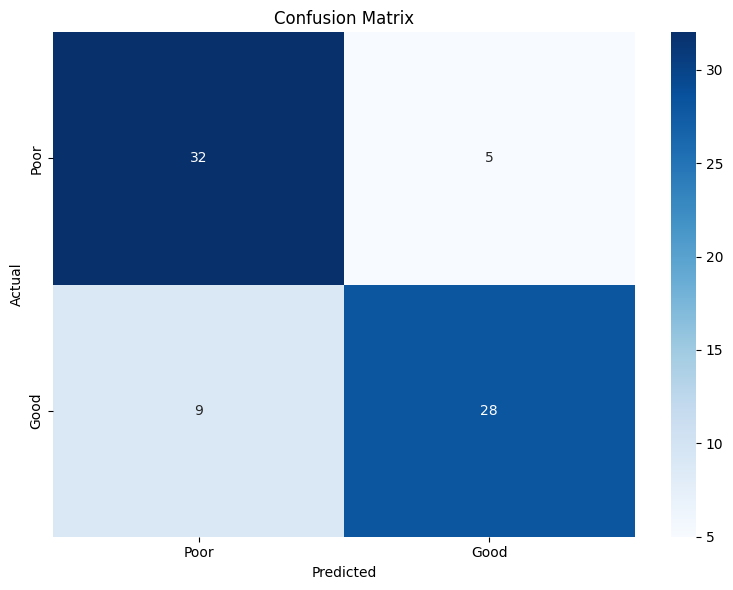

In [35]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = True, xticklabels=['Poor', 'Good'], yticklabels=['Poor', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.pdf', dpi = 300, bbox_inches='tight')
plt.tight_layout()
plt.show()

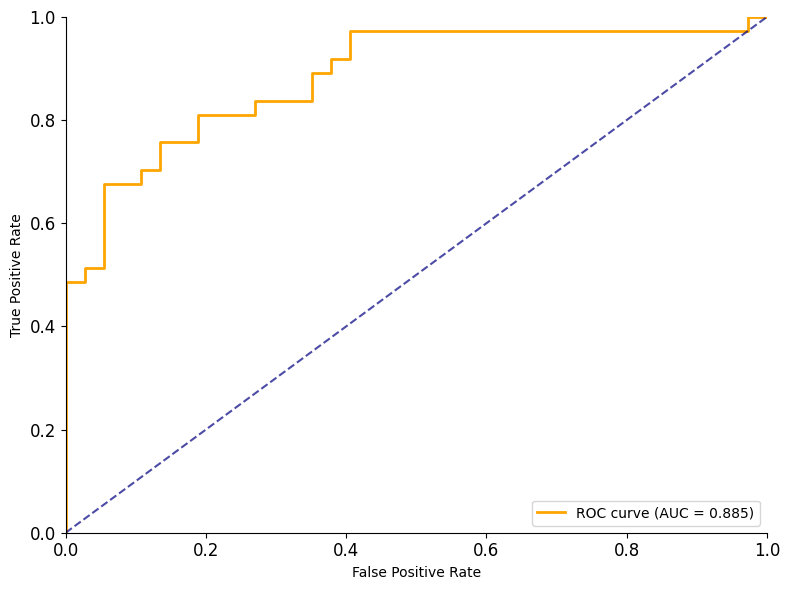

In [37]:
# plot auc curve
fpr, tpr, _ = roc_curve(y_test, y_prob)  # Use y_prob instead of y_pred
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.3f})',color = 'orange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('CBC Mobilizer Classifier – ROC Curve')
plt.legend(loc='lower right')
# plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 1)  # Ensure x-axis starts at 0
plt.ylim(0, 1)  # Ensure y-axis starts at 0
sns.despine()
plt.tight_layout()  
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [38]:
att_extractor = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_extractor.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [39]:
att_extractor

<Functional name=functional_2, built=True>

In [41]:
# save the model 
model.save(here() / config.model_dl / 'attention_aware_final.keras')
# save the attention extractor model
att_extractor.save(here() / config.model_dl /'attention_aware_final.keras')
# save the attention weights
att_df.to_csv(here() / config.model_dl /'attention_aware_final_attnwts.csv', index=False)
# save the training history
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv(here() / config.model_dl / 'attention_aware_final_hist.csv', index=False)
# save the model as pickle
import pickle
with open(here() / config.model_dl / 'attention_aware_final.pkl', 'wb') as f:
    pickle.dump(model, f)
    